In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *

In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario_IGM = {
    'IGM' : ['primordial'],
}

Cs = np.arange(0.300,0.901, 0.100)


In [115]:
def LikelihoodsDM_PopulationTelescope( scenario={}, C=1., population='SMD', telescope='Parkes', FRBs=None, plot_distribution=False, ax=None, **kwargs ):
    """ 
    obtain likelihoods of DM of FRBs observed by telescope, assuming cosmic population and DM-redshift ratio C*1000 pc cm^-3 
    
    optionally plot the distribution of DM expected to be observed by telescope in this scenario
    """
    
    ### choose correct scenario
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]

    ## obtain prediction for distribution of DM observed by telescope
    P, x = GetLikelihood_Telescope( measure='DM', telescope=telescope, population=population, **tmp )

    ## if desired, plot the distribution of DM expected to be observed by telescope in this scenario
    if plot_distribution:
        if ax is None:
            fig, ax = plt.subplots()
        PlotLikelihood( x=x, P=P, measure='DM', ax=ax, **kwargs)
        ax.set_ylim(1e-5,1)
        ax.set_title( "%s with %s, assuming DM$/z = %i$ pc cm$^{-3}$" % ( population, telescope, np.round(C*1000,-2) ) )

    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope])
        
    # compute and return likelihood of DM in FRBcat according to this prediction    
    return Likelihoods( measurements=FRBs['DM']-FRBs['DM_gal'], P=P, x=x )


In [116]:
def LikelihoodsC_PopulationTelescope( scenario={}, population='SMD', telescope='Parkes', FRBs=None, plot_distribution=False, ax=None ):
    """ obtain likelihood of C \propto DM/redshift, based on how well distribution of DM as observed by telescope resembles expectation according to population """
    
    likelihoods = []
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )
    
    if plot_distribution:
        if ax is None:
            fig, ax = plt.subplots()

    ## copmute likelihoods for each value of C
    for C, color in zip( Cs, Rainbow(Cs) ):
        likelihoods.append( LikelihoodsDM_PopulationTelescope( C=C, FRBs=FRBs, population=population, telescope=telescope, plot_distribution=plot_distribution, ax=ax, color=color ) )
        
    if plot_distribution:
        ax.set_title( "%s with %s, assuming DM$ = C 1000z$ pc cm$^{-3}$" % ( population, telescope ) )
        Colorbar( Cs, label=r"$f_{\rm IGM}$" )
    ## return raw likelihoods    
    return np.array(likelihoods)

In [117]:

def BayesC_PopulationTelescope( scenario={}, population='SMD', telescope='Parkes', plot_bayes=False, plot_distribution=False, ax=None, **kwargs):
    """ 
    obtain Bayes factor of C propto DM/z inferred from DM of FRBs observed with telescope, assuming population
    
    optionally plot the resulting bayes factor
    """
    
    
    ## compute  likelihood for all choices of C
    likelihoods = LikelihoodsC_PopulationTelescope( population=population, telescope=telescope, plot_distribution=plot_distribution )
    N_FRBs = likelihoods.shape[1]
    
    ## compute total Bayes factor = product of likelihoods renormalized to one choice of C
    bayes = np.prod( likelihoods / likelihoods[0].reshape(1,N_FRBs), axis=1 )

    if plot_bayes:
        if ax is None:
            fig, ax = plt.subplots()
                               
        PlotBayes( x=Cs, y=bayes, label=r"$f_{\rm IGM}$", width=0.03, ax=ax, title=r"%s with %s, $N_{FRBs} = %i$" % (population, telescope, N_FRBs), **kwargs )
    return bayes
                            

In [118]:
def PlotBayesC_Population( scenario={}, population='SMD', plot_bayes_telescope=False, plot_distribution=False, **kwargs):
    """ obtain Bayes factor of C propto DM/z inferred from DM of FRBs observed by any of telescopes, assuming population """
    
    bayes = []
    if plot_bayes_telescope:
        fig, axs = plt.subplots(1,len(telescopes),figsize=(4*len(telescopes),3))
    else:
        axs = [None]*len(telescopes)
        
    ## obtain bayes factors of C for each telescope
    for telescope, ax in zip( telescopes, axs ):
        bayes.append( BayesC_PopulationTelescope( population=population, telescope=telescope, plot_bayes=plot_bayes_telescope, plot_distribution=plot_distribution, ax=ax ) )
    if plot_bayes_telescope:
        plt.tight_layout()
        
    ## multiply results
    bayes = np.prod(bayes, axis=0)
    
    ## plot final likelihood estimate
    PlotBayes( x=Cs, y=bayes, label=r"$f_{\rm IGM}$", width=0.03, title=population, **kwargs )


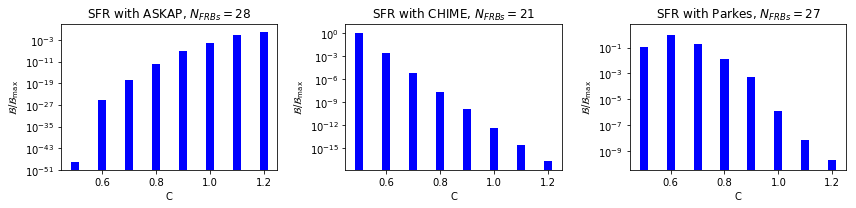

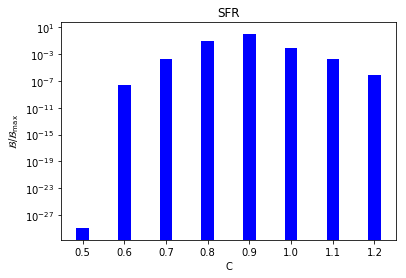

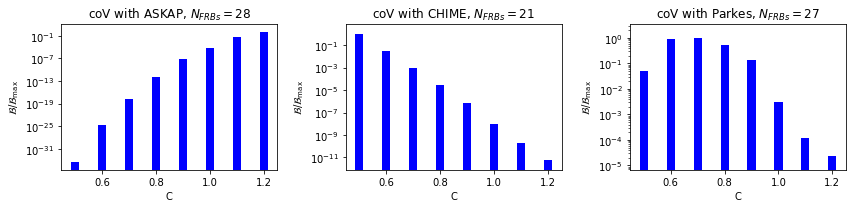

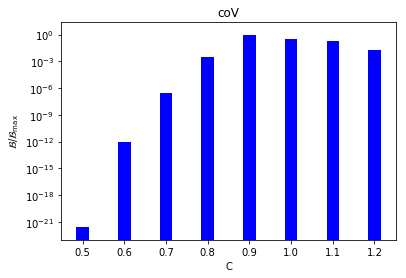

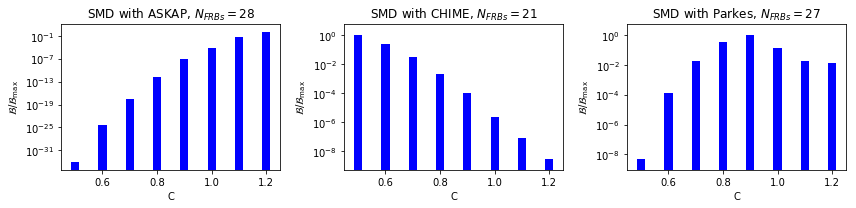

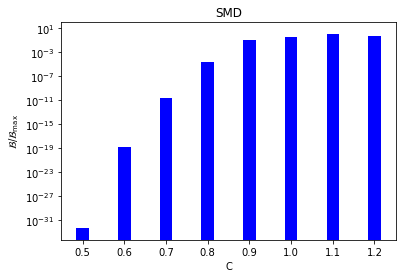

In [120]:
for population in populations:
    PlotBayesC_Population( scenario=scenario, population=population, plot_bayes_telescope=True )

In [12]:
Planck15.lookback_distance(1.0)

<Quantity 2432.90255876 Mpc>

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from scipy import integrate


rho_crit = Planck15.critical_density0.value # g/cm3
omega_b = Planck15.Ob0
omega_m = Planck15.Om0
omega_L = Planck15.Ode0
m_p = 1.67e-24 # g
mu_e = 1.16
c = 2.99e8 # m/s
H_0 = 1./Planck15.hubble_time.value

n_e = rho_crit * omega_b  / m_p / mu_e

def DM(z, f_IGM=0.82):
    return n_e * f_IGM *c/H_0* integrate.quad( lambda z: (1+z)/( omega_m*(1+z)**3 + omega_L )**0.5, 0, z)[0]
    #return n_e * f_IGM * Distance( unit=u.pc, z = z, cosmology = Planck15).parsec

Find fit for results of primordial IGM model with DM $ = C \times z \times 1000 \rm~ pc~ cm^{-3}$

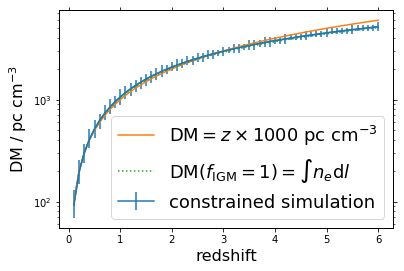

In [4]:
fig, ax = plt.subplots()

PlotAverageEstimate( measure='DM', scenario=scenario_IGM, label='constrained simulation', ax=ax)

C_primordial = 1

ax.plot( redshift_bins, redshift_bins*1000*C_primordial, label=r"DM$ = z \times 1000$ pc cm$^{-3}$" )
ax.plot( redshift_bins, [DM(z , f_IGM=1.) for z in redshift_bins], label=r"DM$(f_{\rm IGM}=1) = \int n_e {\rm d}l$", linestyle=':' )

ax.legend(fontsize=18)
AllSidesTicks(ax)

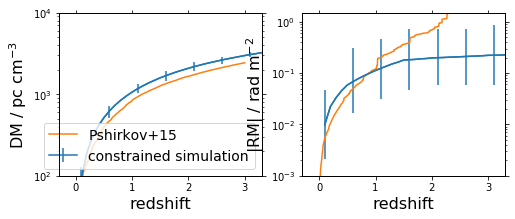

In [12]:
## compare to pshirkov estimate
import DM_Hackstein
B0 = 1e-3 # muG  at n_0=1.8e-7
l_c = 1 # Mpc    correlation length
z_max = 3.0

LoS = DM_Hackstein.Sightline( B0, l_c )

zs, dens = LoS.CreateArrays( z_max )
#DMs = HowLong( LoS.DispersionMeasure, dens, zs )
#RMs = HowLong( LoS.RotationMeasure, dens, zs )

N=10

DMs = [ LoS.DispersionMeasure( *LoS.CreateArrays( z_max )[::-1] ) for i in range(N)]
RMs = [ np.abs(LoS.RotationMeasure( *LoS.CreateArrays( z_max )[::-1])) for i in range(N)]



DM_mean = np.mean(DMs, axis=0)
DM_std = np.std(DMs, axis=0)
RM_mean = np.mean(RMs, axis=0)
RM_std = np.std(RMs, axis=0)
fig, axs = plt.subplots( 1, 2, figsize=(8,3))

PlotAverageEstimate( measure='DM', scenario=scenario_IGM, label='constrained simulation', ax=axs[0], errorevery=5)
PlotAverageEstimate( measure='RM', scenario=scenario_IGM, label='constrained simulation', ax=axs[1], errorevery=5)
axs[0].plot( zs, DM_mean, label='Pshirkov+15')
axs[1].plot( zs, RM_mean, label='Pshirkov+15')

axs[0].set_ylim(1e2,1e4)
axs[0].set_xlim(-0.3,3.3)
axs[1].set_xlim(-0.3,3.3)
axs[1].set_ylim(1e-3,1.5e0)
axs[0].legend(fontsize=14, loc=4)
for ax in axs:
    AllSidesTicks(ax)
#fig.tight_layout()

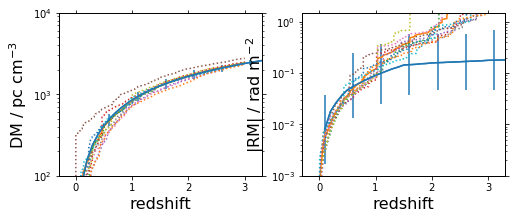

In [15]:
fig, axs = plt.subplots( 1, 2, figsize=(8,3))
tmp = { 'IGM': ['primordial_C800']}
PlotAverageEstimate( measure='DM', scenario=tmp, label='constrained simulation', ax=axs[0], errorevery=5)
PlotAverageEstimate( measure='RM', scenario=tmp, label='constrained simulation', ax=axs[1], errorevery=5)

axs[0].plot( zs, DM_mean, label='Pshirkov+15')
axs[1].plot( zs, RM_mean, label='Pshirkov+15')
#axs[0].errorbar( zs, DM_mean, yerr=DM_std, label='Pshirkov+15', errorevery=300)
#axs[1].errorbar( zs, RM_mean, yerr=RM_std, label='Pshirkov+15', errorevery=300)

for DM in DMs:
    axs[0].plot( zs, DM, label='Pshirkov+15', linestyle=':')
for RM in RMs:
    axs[1].plot( zs, RM, label='Pshirkov+15', linestyle=':')


axs[0].set_ylim(1e2,1e4)
axs[0].set_xlim(-0.3,3.3)
axs[1].set_xlim(-0.3,3.3)
axs[1].set_ylim(1e-3,1.5e0)
#axs[0].legend(fontsize=14, loc=4)
for ax in axs:
    AllSidesTicks(ax)

In [11]:
n0 = 1.8e-7
B0 = 1e-9
print( B0 * 1e5**(2./3) )


2.154434690031883e-06


compute DM & RM likelihoods for other choices of $f_{\rm IGM}$, $P(DM|f_{\rm IGM}) = f_{\rm IGM} \cdot P(f_{\rm IGM} \cdot DM )$, same for RM,  and save to likelihood file

In [4]:

for C in Cs:
    for z in redshift_bins:
        for measure in ['DM', '|RM|'][1:]:
#        fig, ax = plt.subplots()
            P, x = GetLikelihood_Full( measure=measure, redshift=z, **scenario_IGM)
#        PlotLikelihood( x=x, P=P, measure='DM', ax=ax)
            P, x = LikelihoodShift( P=P, x=x, shift=C )
#        print( np.sum(P*np.diff(x)) )
#        PlotLikelihood( x=x, P=P, measure='DM', ax=ax)
            print( [ KeyIGM( redshift=z, measure=measure, model="%s_C%.0f" % ( scenario_IGM['IGM'][0], C*1000 ) , axis=axis  ) for axis in ['P','x'] ])
            Write2h5( likelihood_file_IGM, datas=[P,x], keys=[ KeyIGM( redshift=z, measure=measure, model="%s_C%.0f" % ( scenario_IGM['IGM'][0], C*1000 ) , axis=axis  ) for axis in ['P','x'] ] )
        
        
#        plt.show()



['primordial/far/4/|RM|/0.1000/P', 'primordial/far/4/|RM|/0.1000/x']
['primordial_C300/far/4/|RM|/0.1000/P', 'primordial_C300/far/4/|RM|/0.1000/x']
['primordial/far/4/|RM|/0.2000/P', 'primordial/far/4/|RM|/0.2000/x']
['primordial_C300/far/4/|RM|/0.2000/P', 'primordial_C300/far/4/|RM|/0.2000/x']
['primordial/far/4/|RM|/0.3000/P', 'primordial/far/4/|RM|/0.3000/x']
['primordial_C300/far/4/|RM|/0.3000/P', 'primordial_C300/far/4/|RM|/0.3000/x']
['primordial/far/4/|RM|/0.4000/P', 'primordial/far/4/|RM|/0.4000/x']
['primordial_C300/far/4/|RM|/0.4000/P', 'primordial_C300/far/4/|RM|/0.4000/x']
['primordial/far/4/|RM|/0.5000/P', 'primordial/far/4/|RM|/0.5000/x']
['primordial_C300/far/4/|RM|/0.5000/P', 'primordial_C300/far/4/|RM|/0.5000/x']
['primordial/far/4/|RM|/0.6000/P', 'primordial/far/4/|RM|/0.6000/x']
['primordial_C300/far/4/|RM|/0.6000/P', 'primordial_C300/far/4/|RM|/0.6000/x']
['primordial/far/4/|RM|/0.7000/P', 'primordial/far/4/|RM|/0.7000/x']
['primordial_C300/far/4/|RM|/0.7000/P', 'pr

['primordial_C400/far/4/|RM|/2.4000/P', 'primordial_C400/far/4/|RM|/2.4000/x']
['primordial/far/4/|RM|/2.5000/P', 'primordial/far/4/|RM|/2.5000/x']
['primordial_C400/far/4/|RM|/2.5000/P', 'primordial_C400/far/4/|RM|/2.5000/x']
['primordial/far/4/|RM|/2.6000/P', 'primordial/far/4/|RM|/2.6000/x']
['primordial_C400/far/4/|RM|/2.6000/P', 'primordial_C400/far/4/|RM|/2.6000/x']
['primordial/far/4/|RM|/2.7000/P', 'primordial/far/4/|RM|/2.7000/x']
['primordial_C400/far/4/|RM|/2.7000/P', 'primordial_C400/far/4/|RM|/2.7000/x']
['primordial/far/4/|RM|/2.8000/P', 'primordial/far/4/|RM|/2.8000/x']
['primordial_C400/far/4/|RM|/2.8000/P', 'primordial_C400/far/4/|RM|/2.8000/x']
['primordial/far/4/|RM|/2.9000/P', 'primordial/far/4/|RM|/2.9000/x']
['primordial_C400/far/4/|RM|/2.9000/P', 'primordial_C400/far/4/|RM|/2.9000/x']
['primordial/far/4/|RM|/3.0000/P', 'primordial/far/4/|RM|/3.0000/x']
['primordial_C400/far/4/|RM|/3.0000/P', 'primordial_C400/far/4/|RM|/3.0000/x']
['primordial/far/4/|RM|/3.1000/P'

['primordial/far/4/|RM|/4.5000/P', 'primordial/far/4/|RM|/4.5000/x']
['primordial_C500/far/4/|RM|/4.5000/P', 'primordial_C500/far/4/|RM|/4.5000/x']
['primordial/far/4/|RM|/4.6000/P', 'primordial/far/4/|RM|/4.6000/x']
['primordial_C500/far/4/|RM|/4.6000/P', 'primordial_C500/far/4/|RM|/4.6000/x']
['primordial/far/4/|RM|/4.7000/P', 'primordial/far/4/|RM|/4.7000/x']
['primordial_C500/far/4/|RM|/4.7000/P', 'primordial_C500/far/4/|RM|/4.7000/x']
['primordial/far/4/|RM|/4.8000/P', 'primordial/far/4/|RM|/4.8000/x']
['primordial_C500/far/4/|RM|/4.8000/P', 'primordial_C500/far/4/|RM|/4.8000/x']
['primordial/far/4/|RM|/4.9000/P', 'primordial/far/4/|RM|/4.9000/x']
['primordial_C500/far/4/|RM|/4.9000/P', 'primordial_C500/far/4/|RM|/4.9000/x']
['primordial/far/4/|RM|/5.0000/P', 'primordial/far/4/|RM|/5.0000/x']
['primordial_C500/far/4/|RM|/5.0000/P', 'primordial_C500/far/4/|RM|/5.0000/x']
['primordial/far/4/|RM|/5.1000/P', 'primordial/far/4/|RM|/5.1000/x']
['primordial_C500/far/4/|RM|/5.1000/P', 'pr

['primordial/far/4/|RM|/0.7000/P', 'primordial/far/4/|RM|/0.7000/x']
['primordial_C700/far/4/|RM|/0.7000/P', 'primordial_C700/far/4/|RM|/0.7000/x']
['primordial/far/4/|RM|/0.8000/P', 'primordial/far/4/|RM|/0.8000/x']
['primordial_C700/far/4/|RM|/0.8000/P', 'primordial_C700/far/4/|RM|/0.8000/x']
['primordial/far/4/|RM|/0.9000/P', 'primordial/far/4/|RM|/0.9000/x']
['primordial_C700/far/4/|RM|/0.9000/P', 'primordial_C700/far/4/|RM|/0.9000/x']
['primordial/far/4/|RM|/1.0000/P', 'primordial/far/4/|RM|/1.0000/x']
['primordial_C700/far/4/|RM|/1.0000/P', 'primordial_C700/far/4/|RM|/1.0000/x']
['primordial/far/4/|RM|/1.1000/P', 'primordial/far/4/|RM|/1.1000/x']
['primordial_C700/far/4/|RM|/1.1000/P', 'primordial_C700/far/4/|RM|/1.1000/x']
['primordial/far/4/|RM|/1.2000/P', 'primordial/far/4/|RM|/1.2000/x']
['primordial_C700/far/4/|RM|/1.2000/P', 'primordial_C700/far/4/|RM|/1.2000/x']
['primordial/far/4/|RM|/1.3000/P', 'primordial/far/4/|RM|/1.3000/x']
['primordial_C700/far/4/|RM|/1.3000/P', 'pr

['primordial_C800/far/4/|RM|/2.8000/P', 'primordial_C800/far/4/|RM|/2.8000/x']
['primordial/far/4/|RM|/2.9000/P', 'primordial/far/4/|RM|/2.9000/x']
['primordial_C800/far/4/|RM|/2.9000/P', 'primordial_C800/far/4/|RM|/2.9000/x']
['primordial/far/4/|RM|/3.0000/P', 'primordial/far/4/|RM|/3.0000/x']
['primordial_C800/far/4/|RM|/3.0000/P', 'primordial_C800/far/4/|RM|/3.0000/x']
['primordial/far/4/|RM|/3.1000/P', 'primordial/far/4/|RM|/3.1000/x']
['primordial_C800/far/4/|RM|/3.1000/P', 'primordial_C800/far/4/|RM|/3.1000/x']
['primordial/far/4/|RM|/3.2000/P', 'primordial/far/4/|RM|/3.2000/x']
['primordial_C800/far/4/|RM|/3.2000/P', 'primordial_C800/far/4/|RM|/3.2000/x']
['primordial/far/4/|RM|/3.3000/P', 'primordial/far/4/|RM|/3.3000/x']
['primordial_C800/far/4/|RM|/3.3000/P', 'primordial_C800/far/4/|RM|/3.3000/x']
['primordial/far/4/|RM|/3.4000/P', 'primordial/far/4/|RM|/3.4000/x']
['primordial_C800/far/4/|RM|/3.4000/P', 'primordial_C800/far/4/|RM|/3.4000/x']
['primordial/far/4/|RM|/3.5000/P'

['primordial/far/4/|RM|/4.7000/P', 'primordial/far/4/|RM|/4.7000/x']
['primordial_C900/far/4/|RM|/4.7000/P', 'primordial_C900/far/4/|RM|/4.7000/x']
['primordial/far/4/|RM|/4.8000/P', 'primordial/far/4/|RM|/4.8000/x']
['primordial_C900/far/4/|RM|/4.8000/P', 'primordial_C900/far/4/|RM|/4.8000/x']
['primordial/far/4/|RM|/4.9000/P', 'primordial/far/4/|RM|/4.9000/x']
['primordial_C900/far/4/|RM|/4.9000/P', 'primordial_C900/far/4/|RM|/4.9000/x']
['primordial/far/4/|RM|/5.0000/P', 'primordial/far/4/|RM|/5.0000/x']
['primordial_C900/far/4/|RM|/5.0000/P', 'primordial_C900/far/4/|RM|/5.0000/x']
['primordial/far/4/|RM|/5.1000/P', 'primordial/far/4/|RM|/5.1000/x']
['primordial_C900/far/4/|RM|/5.1000/P', 'primordial_C900/far/4/|RM|/5.1000/x']
['primordial/far/4/|RM|/5.2000/P', 'primordial/far/4/|RM|/5.2000/x']
['primordial_C900/far/4/|RM|/5.2000/P', 'primordial_C900/far/4/|RM|/5.2000/x']
['primordial/far/4/|RM|/5.3000/P', 'primordial/far/4/|RM|/5.3000/x']
['primordial_C900/far/4/|RM|/5.3000/P', 'pr

plot redshift evolution of $\langle$DM$\rangle$

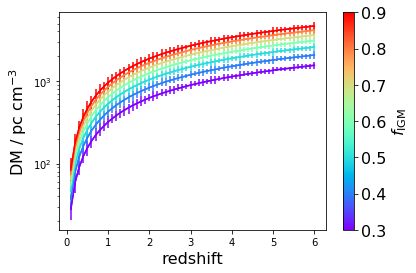

In [24]:
fig, ax = plt.subplots()

for C, color in zip( Cs, Rainbow(Cs) ):
    tmp = scenario_IGM.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    PlotAverageEstimate( measure='DM', scenario=tmp, ax=ax, color=color )
Colorbar(Cs, label=r"$f_{\rm IGM}$")

make redshift estimates for a given scenario

In [4]:
## choose scenario with different DM-redshift-relation
C=0.7
tmp = scenario.copy()
tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]

## estimate redshifts, considering selection effects of telescopes and assuming different cosmic populations as prior likelihood
## results are written to npy file, FilenameEstimatedRedshift( tmp )
FRBcatEstimateRedshifts( scenario=tmp )

In [6]:
## read estimated redshifts of scenario into structured numpy array
redshift_estimates = GetEstimatedRedshifts( scenario=tmp )

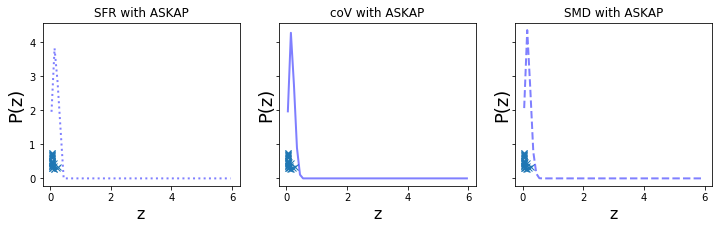

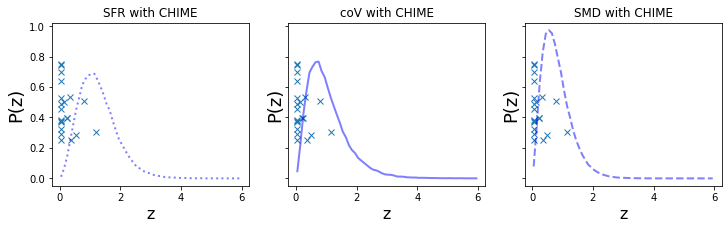

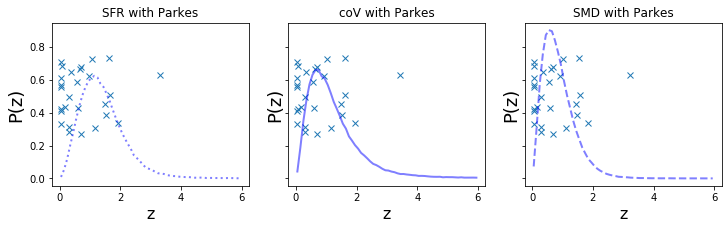

In [7]:
### see how well the obtained redshifts compare to assumed population
### compare shape of likelihood function and compute Bayes factor

#FRBs = GetFRBcat(telescopes=telescopes)

likelihoods = np.zeros( [len(redshift_estimates), len(populations)] )


for tele in telescopes:
    ix_tele, = np.where( redshift_estimates['telescope'] == tele )

#    ix_tele, = np.where( FRBs['tele'] == telescopes_FRBcat[tele] )
#    fig, ax = plt.subplots()
#    ax.set_title( tele ) #"%s with %s" % (pop, tele) )
#    ax.plot( redshift_estimates[ix_tele,-2], 0.75-0.5*np.random.rand(len(ix_tele)), marker='x', linestyle=' ' )

    fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
    y_FRBs = 0.75-0.5*np.random.rand(len(ix_tele))
    
#    for ipop, (pop, linestyle) in enumerate(zip(populations, linestyles_population)):

    for ipop, (pop, linestyle, ax) in enumerate(zip(populations, linestyles_population, axs)):
        estimates = redshift_estimates['redshift'+pop]
        ax.set_title( "%s with %s" % (pop, tele) )
        ax.plot( estimates[ix_tele], y_FRBs, marker='x', linestyle=' ' )
#        ax.plot( estimates[ix_tele], y_FRBs, marker='x', linestyle=' ' )

##        P, x = histogram( estimates[ix_tele], bins=60, range=(0,6), log=False, density=True )
##        PlotLikelihood( x=x, P=P, log=False, measure='z', ax=ax, linestyle=linestyle, label=pop, color='black' )
        P, x = GetLikelihood_Redshift( population=pop, telescope=tele )
        PlotLikelihood( x=x, P=P, log=False, label=pop, measure='z', ax=ax, linestyle=linestyle, linewidth=2, alpha=0.5, color='blue' )
    
        likelihoods[ix_tele,ipop] = Likelihoods( measurements=estimates[ix_tele], P=P, x=x )
#    ax.legend()
plt.show()

        
likelihoods /= likelihoods[:,0].repeat( likelihoods.shape[1] ).reshape( *likelihoods.shape )

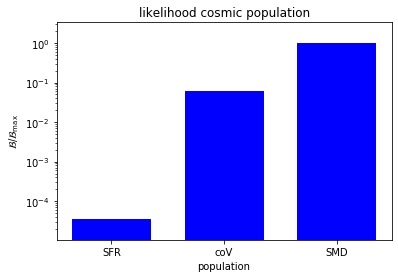

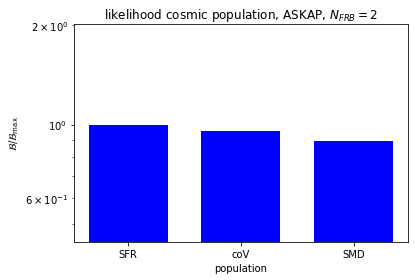

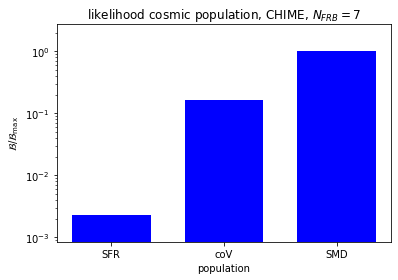

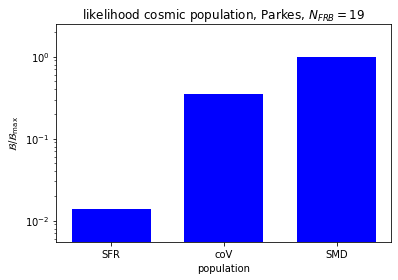

In [12]:

## only use FRBs with reasonable redshift estimates
#ix_reasonable, = np.where(redshift_estimates['redshiftSMD'][ix_tele]<4.5)*(redshift_estimates['redshiftSMD'][ix_tele]>0.05)
ix_reasonable, = np.where( redshift_estimates['redshiftSMD']>0.15 )

#print( likelihoods[ ix_reasonable  ] )
bayes = np.prod( likelihoods[ ix_reasonable  ], axis=0 )

#print(bayes)

PlotBayes( x=populations, y=bayes, width=0.7, label='population', title='likelihood cosmic population' )

plt.show()


for tele in telescopes:
    ix_tele, = np.where( redshift_estimates['telescope'][ix_reasonable] == tele )
    ls = likelihoods[ix_reasonable[ix_tele]]
#    print(ls)
    bayes = np.prod( ls, axis=0 )
#    bayes = np.prod( likelihoods[ (redshift_estimates[:,0]<4.5)*(redshift_estimates[:,0]>0.05)  ], axis=0 )
    PlotBayes( x=populations, y=bayes, width=0.7, label='population', title='likelihood cosmic population, %s, $N_{FRB} = %i$' % ( tele, len( ix_tele ) ) )

    plt.show()

In [12]:
def LikelihoodPopulation_( redshift_estimates=[], plot_distribution=False, renormalize=True ):
    """
    compute likelihood of population based on how well redshift estimates resemble expected distribution
    """
    
    
    ## read redshifts of FRBs in FRBcat, estimated assuming scenario
#    redshift_estimates = GetEstimatedRedshifts( scenario )

    ### see how well the obtained redshifts compare to assumed population
    ### compare shape of prior and posterior likelihood function by computing Bayes factors

    likelihoods = np.zeros( [len(redshift_estimates), len(populations)] )

    
    for tele in telescopes:
        
        ## find FRBs observed by this telescope
        ix_tele, = np.where( redshift_estimates['telescope'] == tele )

        if plot_distribution:
            fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
            y_FRBs = 0.75-0.5*np.random.rand(len(ix_tele))
    
        for ipop, (pop, linestyle) in enumerate(zip(populations, linestyles_population)):

            ## get redshift estimates that assume this population
            estimates = redshift_estimates['redshift'+pop]
        
            ## get expected distribution of redshifts
            P, x = GetLikelihood_Redshift( population=pop, telescope=tele )
        
            ## compute the likelihood of estimated redshifts according to expected distribution
            likelihoods[ix_tele,ipop] = Likelihoods( measurements=estimates[ix_tele], P=P, x=x )
    
            if plot_distribution:
                axs[ipop].set_title( "%s with %s" % (pop, tele) )
            
                ## plot estimated redshifts
                axs[ipop].plot( estimates[ix_tele], y_FRBs, marker='x', linestyle=' ' )
            
                ## and their assumed == expected distribution
                PlotLikelihood( x=x, P=P, log=False, label=pop, measure='z', ax=axs[ipop], linestyle=linestyle, linewidth=2, alpha=0.5, color='blue' )
    
        if plot_distribution:
            plt.show()

    if renormalize:
        ## renormlize likelihood to first population -> Bayes factors for population    
        likelihoods /= likelihoods[:,0].repeat( likelihoods.shape[1] ).reshape( *likelihoods.shape )

    return likelihoods


    
def BayesBaryonContent_old( scenario={} ):
    """ 
    compute and plot bayes factor of C in DM = C * z * 1000 pc cm^-3, obtained by comparing how well estimates of redshift of FRBs in FRBcat resemble distribution expected from cosmic population 
    
    !!! ATTENTION !!! by only using estimate of redshift, we ignore uncertainties on that redshift and arrive at artificially precise conclusions.
    !!! DO NOT TRUST RESULTS !!!
    
    """

    likelihoods = []
    
    
    for C in Cs:
        tmp = scenario.copy()
        tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
        
        redshift_estimates = GetEstimatedRedshifts( tmp )
        
        likelihoods.append( LikelihoodPopulations( redshift_estimates=redshift_estimates, renormalize=False) )

#        ix_reasonable, = np.where( redshift_estimates['redshiftSMD']>0.15 )
#        ixs_reasonable.append( ix_reasonable )

    ix_reasonable, = np.where( redshift_estimates['redshiftSMD']>0.15 )

    ## renormlize likelihoods to first scenario -> Bayes factors for scenarios
    likelihoods = np.array(likelihoods)
    likelihoods = likelihoods / likelihoods[0]#.reshape( [likelihoods.shape[0], likelihoods.shape[1], len(Cs)] )
    
    print(likelihoods.shape)
    
    bayes = np.prod( likelihoods, axis=1 )
    for ipop, population in enumerate( populations ):
        PlotBayes( x=Cs, y=bayes[:,ipop], width=0.03, label=r"$f_{\rm IGM}$", title=population+', likelihood DM=$C$ $z$ 1000 pc cm$^{-3}$')
        plt.show()
        
        
    ## make contour plot to compare all bayes factors at once
    
    x = np.linspace(0.5,1.3,len(Cs))
    y = np.arange(-1,2)                                
    xy_x, xy_y = np.meshgrid( y, x )
                                 
    lvl_min = 1e-5
    levels = np.linspace( np.log10(lvl_min), 0, 200 )
    colors = Rainbow( levels )
    levels = 10.**levels
    from matplotlib.colors import LogNorm
        
    plt.imshow( bayes[::-1]/bayes.max(), cmap=rainbow, extent=[0,30,0,50], norm=LogNorm( vmin=1e-5) )
    plt.xticks( [5,15,25], populations )
    off = float(50)/len(Cs)/2
    plt.yticks( np.linspace(off,50-off,len(Cs)), np.round(Cs,1) )
    
#    print(bayes/bayes.max())
                                
#    plt.contourf(xy_x, xy_y, bayes/bayes.max(), levels, colors=colors )
#    plt.xticks( y*2/4, populations )
    plt.ylabel(r"$f_{\rm IGM}$")
    Colorbar( np.log10(levels), label=r"log$_{10}\left(\mathcal{B}/\mathcal{B}_{\rm max}\right)$" )
    plt.show()
    
                                 
                                 

(8, 76, 3)


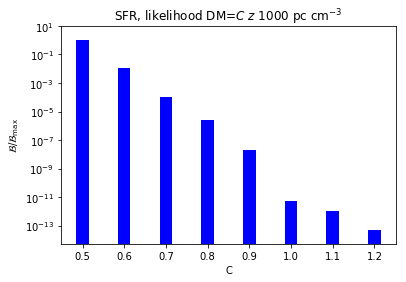

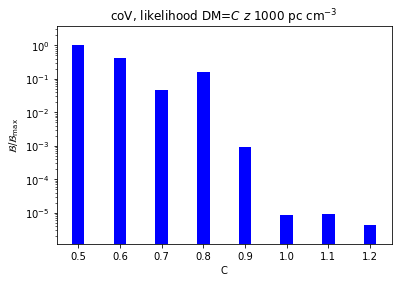

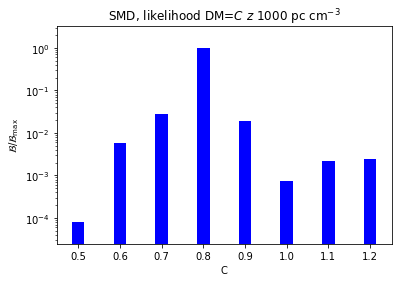

[[7.93186825e-05 7.93186825e-05 7.93186825e-05]
 [9.03976958e-07 3.40931395e-05 5.67937620e-03]
 [7.98379278e-09 3.61090440e-06 2.72608613e-02]
 [2.12863387e-10 1.23575920e-05 1.00000000e+00]
 [1.68128596e-12 7.26028410e-08 1.89345964e-02]
 [4.23419673e-16 6.78535101e-10 7.45644585e-04]
 [8.28407336e-17 7.21171363e-10 2.17851738e-03]
 [4.02293970e-18 3.44465765e-10 2.48202505e-03]]


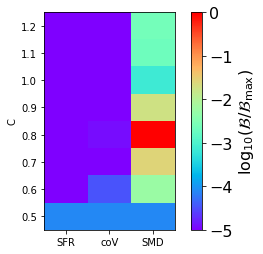

In [4]:
BayesBaryonContent( scenario )

{'Inter': ['Rodrigues18'], 'Host': ['Rodrigues18/smd'], 'IGM': ['primordial_C300'], 'Local': ['Piro18/wind']}


KeyError: 'ASKAP_incoh'

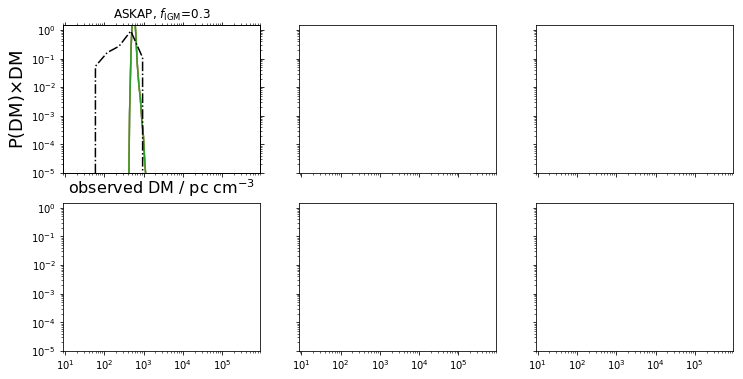

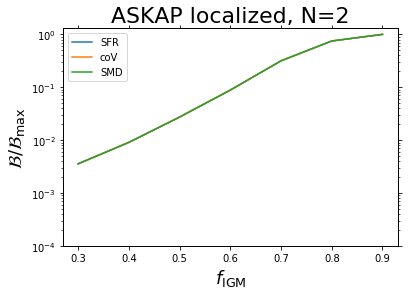

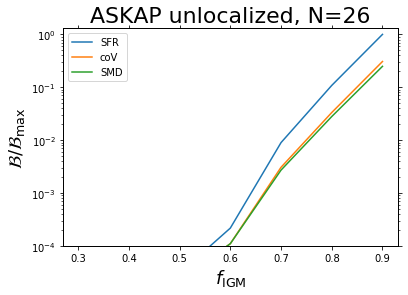

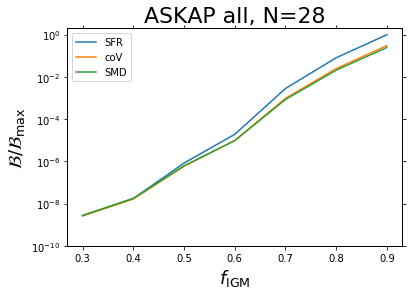

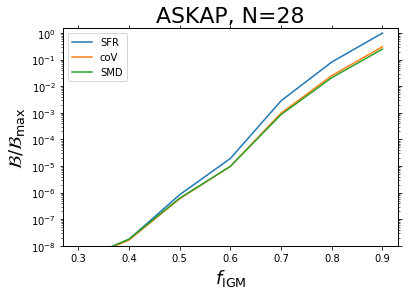

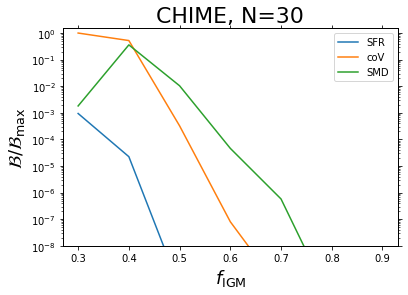

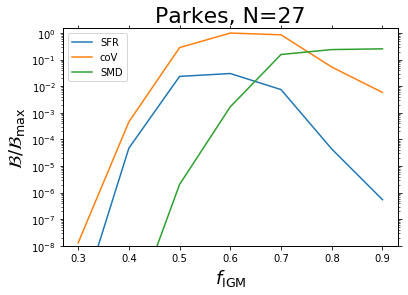

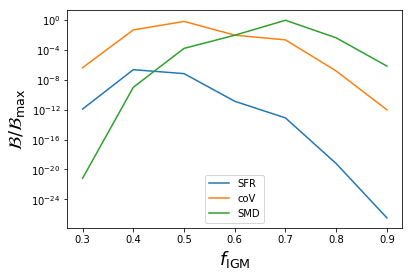

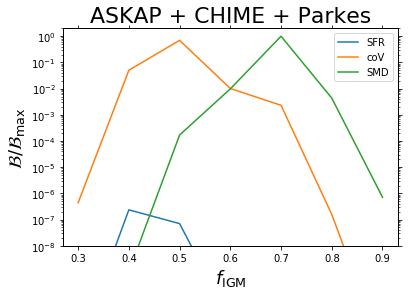

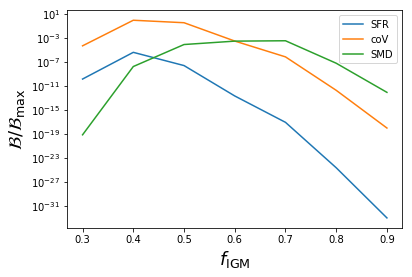

(1e-08, 2)

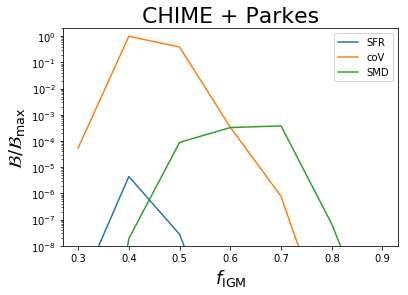

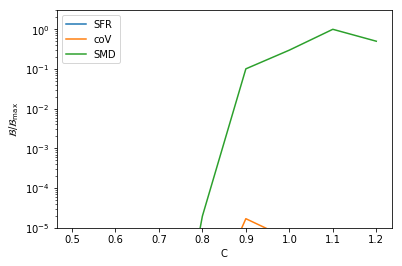

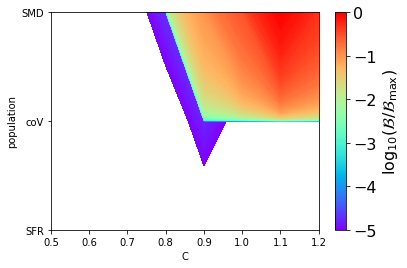

In [143]:
PlotBayes2D( bayes=bayes, x=Cs, y=populations, graphs=True, xlabel=r"$f_{\rm IGM}$" )
plt.ylim(1e-5,3)
plt.show()

PlotBayes2D( bayes=bayes, x=Cs, y=populations, plane=True, xlabel=r"$f_{\rm IGM}$", ylabel='population', P_min=1e-5 )
plt.show()


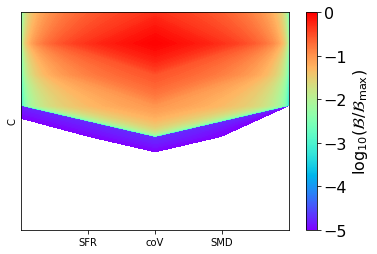

In [42]:
## make contour plot to compare all bayes factors at once
    
x = np.linspace(Cs[0],Cs[-1],len(Cs))
y = np.arange(-1,2)                                
xy_x, xy_y = np.meshgrid( y, x )
                                 
lvl_min = 1e-5
levels = np.linspace( np.log10(lvl_min), 0, 200 )
colors = Rainbow( levels )
levels = 10.**levels
from matplotlib.colors import LogNorm
        
#plt.imshow( bayes[::-1]/bayes.max(), cmap=rainbow, extent=[0,30,0,50], norm=LogNorm( vmin=1e-5) )
#plt.xticks( [5,15,25], populations )
off = float(50)/len(Cs)/2
plt.yticks( np.linspace(off,50-off,len(Cs)), np.round(Cs,1) )
    
#print(bayes/bayes.max())
                                
plt.contourf(xy_x, xy_y, bayes.transpose()/bayes.max(), levels, colors=colors )
plt.xticks( y*2/4, populations )
plt.ylabel(r"$f_{\rm IGM}$")
Colorbar( np.log10(levels), label=r"log$_{10}\left(\mathcal{B}/\mathcal{B}_{\rm max}\right)$" )
plt.show()
  

In [121]:
for C in Cs:
    tmp = scenario_IGM.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    print( r"$f_{\rm IGM}$ = %f" % C )
    try:
        BayesPopulation( tmp )
    except:
        EstimateRedshiftsFRBcat( tmp )
        BayesPopulation( tmp )


C = 0.500000


NameError: name 'PlotBayes' is not defined

C = 0.500000


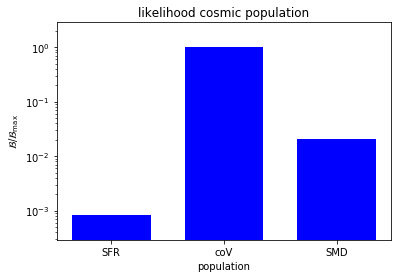

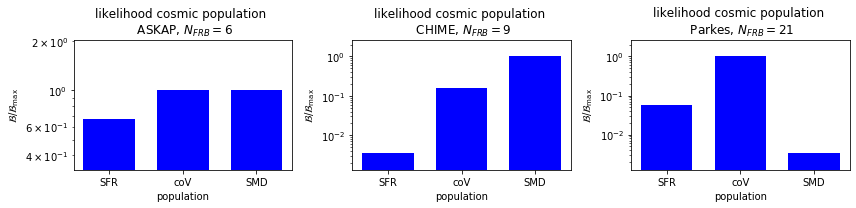

C = 0.600000


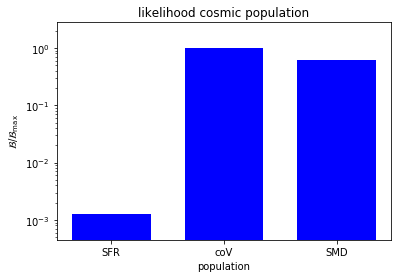

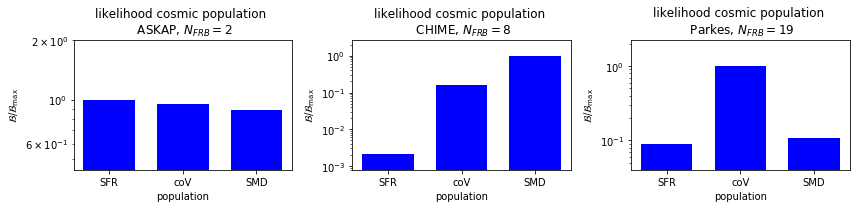

C = 0.700000


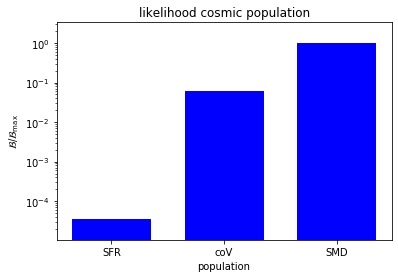

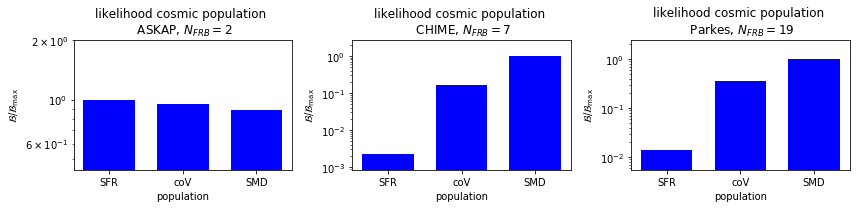

C = 0.800000


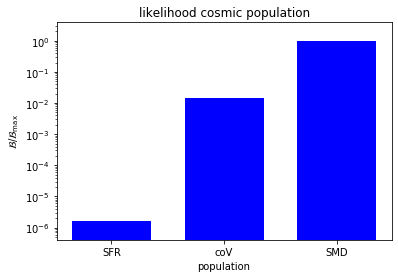

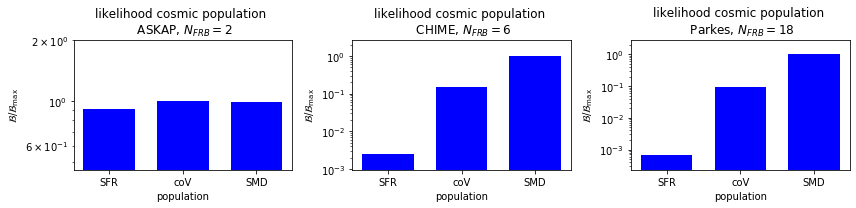

C = 0.900000


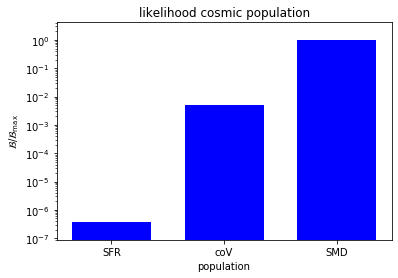

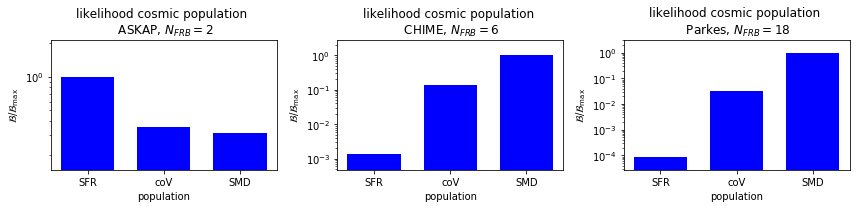

C = 1.000000


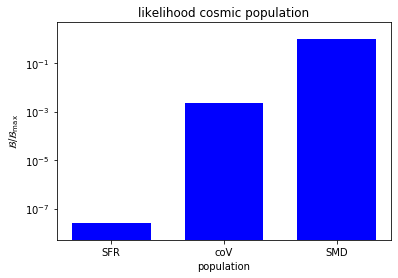

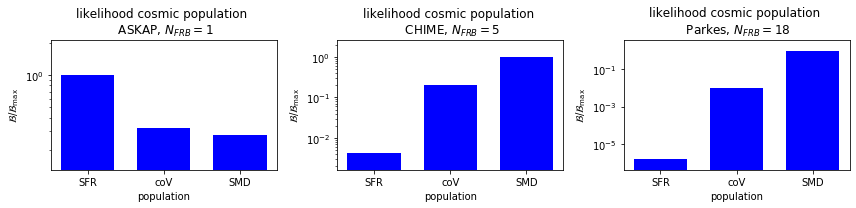

C = 1.100000


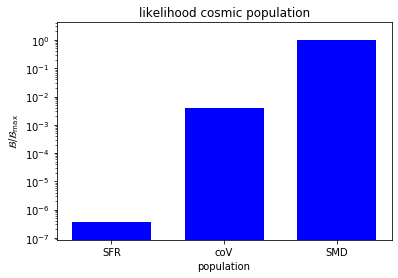

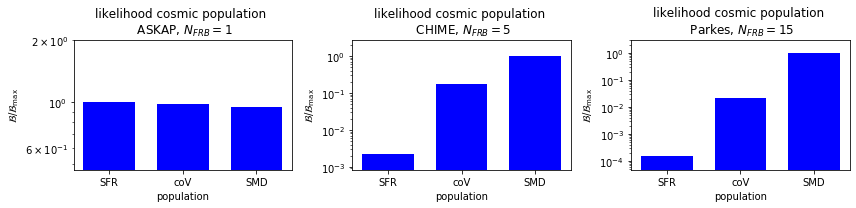

C = 1.200000


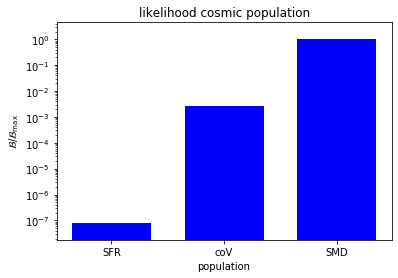

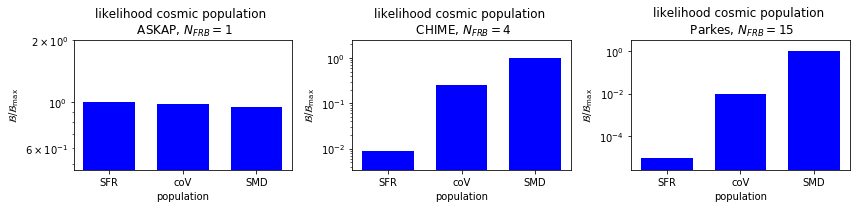

In [8]:
for C in Cs:
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    print( r"$f_{\rm IGM}$ = %f" % C )
    try:
        BayesPopulation( tmp )
    except:
        FRBcatEstimateRedshifts( tmp )
        BayesPopulation( tmp )


In [31]:
LikelihoodPopulation( redshift_estimates ).shape

(76, 3)

In [141]:
def LikelihoodLikelihood( P1=[], P2=[], x=[] ):
    """ compute the likelihood of of likelihood function P1 according to likelihood function P2, both with identical bin-ranges x"""
    return np.sum(P1*P2*np.diff(x)**2)

0.41657124310074806
0.873506722610822
0.6055014611630457


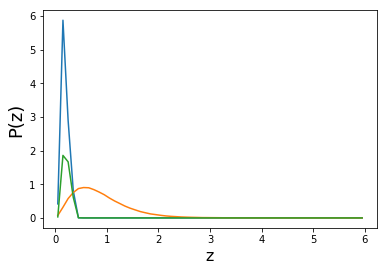

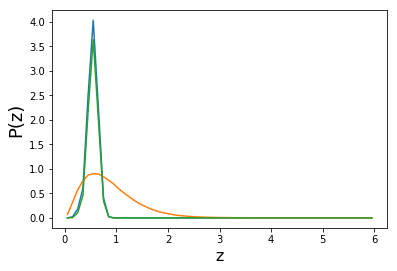

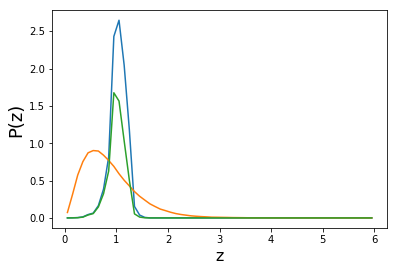

In [132]:
population = 'SMD'
telescope = 'Parkes'
Ps, z = LikelihoodRedshift( DMs=np.array([700,1000,1500]), scenario=scenario, population=population, telescope=telescope )
pi, z =  GetLikelihood_Redshift( population=population, telescope=telescope )

for P in Ps:
    fig, ax = plt.subplots()
    PlotLikelihood( P=P, x=z, measure='z', log=False, ax=ax )
    PlotLikelihood( P=pi, x=z, measure='z', log=False, ax=ax )
    PlotLikelihood( P=P*pi, x=z, measure='z', log=False, ax=ax )
    
    print( LikelihoodLikelihood( P1=P, P2=pi, x=z ))    

    

In [142]:
print( LikelihoodLikelihood( P1=P, P2=P, x=z ), np.sum(P*np.diff(z)))


0.19364439686666432 1.0000000368362767


here we compute the mean DM and plot $P({\rm DM})$ as observed by the investigated telescopes. Note that mean DM requires high number of bins, while $P({\rm DM})$ needs low number of bins in order to plot nicely

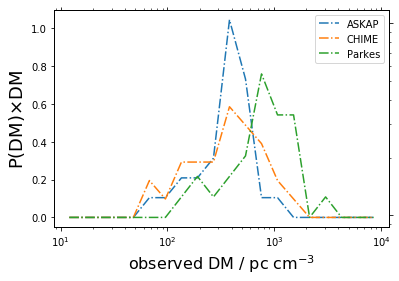

In [214]:
bins = 10   ## good to plot distribution of low number of events
bins = 1000 ## sufficient for converged <DM>

fig, ax = plt.subplots()
for it, telescope in enumerate(telescopes):
    FRBs = GetFRBcat( telescopes=[telescope] )
    DMs = FRBs['DM']-FRBs['DM_gal']
    P_, x_ = histogram( data=DMs, bins=20, log=True, density=True, range=(1e1,1e4) )
    PlotLikelihood( P=P_, x=x_, measure='DM', ax=ax, label=telescope, linestyle='-.', cumulative=0,      )
    #est, dev = Likelihood2Expectation( P=P_, x=x_, log=True, density=True )
    #plt.errorbar( est, 1-float(it)/10, xerr=dev, marker='x' )
    #print( "%f + %f - %f" %( est, dev[1], dev[0] ), "max = %f" % max(DMs) )
AllSidesTicks( ax )
ax.legend()
ax.set_yscale('linear')


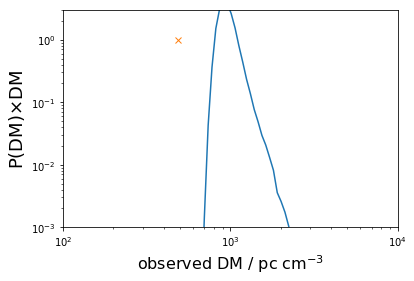

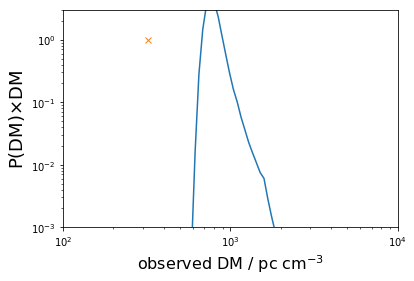

In [4]:
FRBs = GetFRBcat( telescopes=['ASKAP'])
FRBs = FRBs[FRBs['host_redshift']>0]
for FRB in FRBs:
    fig, ax = plt.subplots()
    P_DM, DM = GetLikelihood_Full( measure='DM', redshift=np.round(FRB['host_redshift'],1), **scenario )
    PlotLikelihood( x=DM, P=P_DM, measure='DM', ax=ax )
    ax.plot( FRB['DM']-FRB['DM_gal'], 1, marker='x' )
    ax.set_xlim(1e2,1e4)
    ax.set_ylim(1e-3,3)
    
#    L = Likelihoods( measurements=[FRB['DM']-FRB['DM_gal']], P=P_DM, x=DM )
#    print(L)

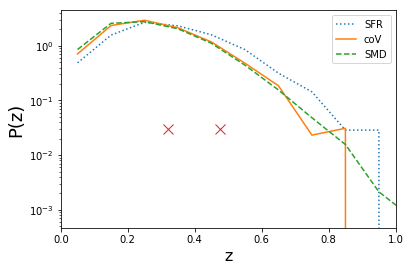

In [5]:
fig, ax = plt.subplots()


P_z_0, z = GetLikelihood_Redshift(  telescope='ASKAP', population='SMD' )
P_z_0_flat, z = GetLikelihood_Redshift(  telescope='None', population='SMD' )
P_z_0 = 1
P_z_0_flat = 1

for population, linestyle in zip( populations, linestyles_population):
    P_z, z = GetLikelihood_Redshift(  telescope='ASKAP_incoh', population=population )
    PlotLikelihood( P=P_z/P_z_0, x=z, measure='z', log=False, ax=ax, label=population, linestyle=linestyle )
#    P_z, z = GetLikelihood_Redshift(  telescope='None', population=population )
#    PlotLikelihood( P=P_z/P_z_0_flat, x=z, log=False, ax=ax, label=population, linestyle=linestyle )
    plt.yscale('log')
plt.plot( FRBs['host_redshift'], [3e-2]*len(FRBs), marker='x', linestyle=' ', markersize=10)
plt.xlim(0,1)
plt.legend()

In [90]:
FRBs

array([('FRB181112', 589.27, 102. , 10.9, nan, 0.4755, 'ASKAP'),
       ('FRB180924', 361.42,  40.5, 14. , nan, 0.3214, 'ASKAP')],
      dtype=[('ID', '<U9'), ('DM', '<f4'), ('DM_gal', '<f4'), ('RM', '<f4'), ('tau', '<f4'), ('host_redshift', '<f4'), ('tele', '<U10')])